<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/image_processing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

# Assuming your file is named 'clean_images.npy' and is accessible
test_array = np.load('clean_images_normalized.npy')

# Print the essential metadata
print(f"File's actual shape: {test_array.shape}")
print(f"File's actual data type: {test_array.dtype}")

File's actual shape: (271, 224, 224, 3)
File's actual data type: float32



Successfully loaded data from clean_images_normalized.npy with initial shape: (271, 224, 224, 3)
Starting augmentation... Generating 5 augmented versions for each of the 271 images.
Processed and augmented 50/271 images...
Processed and augmented 100/271 images...
Processed and augmented 150/271 images...
Processed and augmented 200/271 images...
Processed and augmented 250/271 images...

Augmentation complete!
Original image count: 271
Final image count: 1626 (Original + 5 Augmented versions)
Final dataset shape: (1626, 224, 224, 3)

Final augmented dataset saved to: augmented_training_data.npy

VERIFICATION: Displaying 3 original images to confirm successful loading...


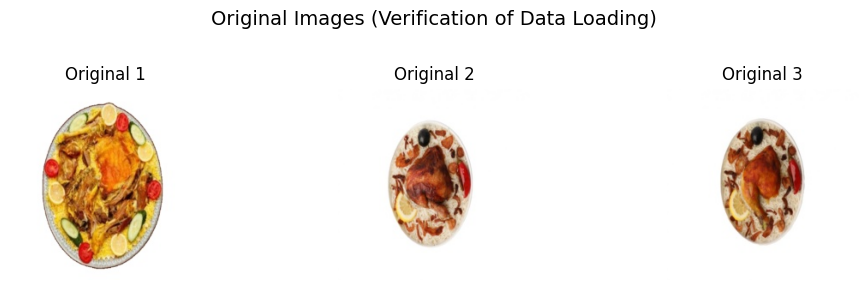


VERIFICATION: Displaying one original image and its 5 augmented versions...
DEBUG: Data type of final_array: uint8
DEBUG: Pixel range check (Min/Max): 0/255


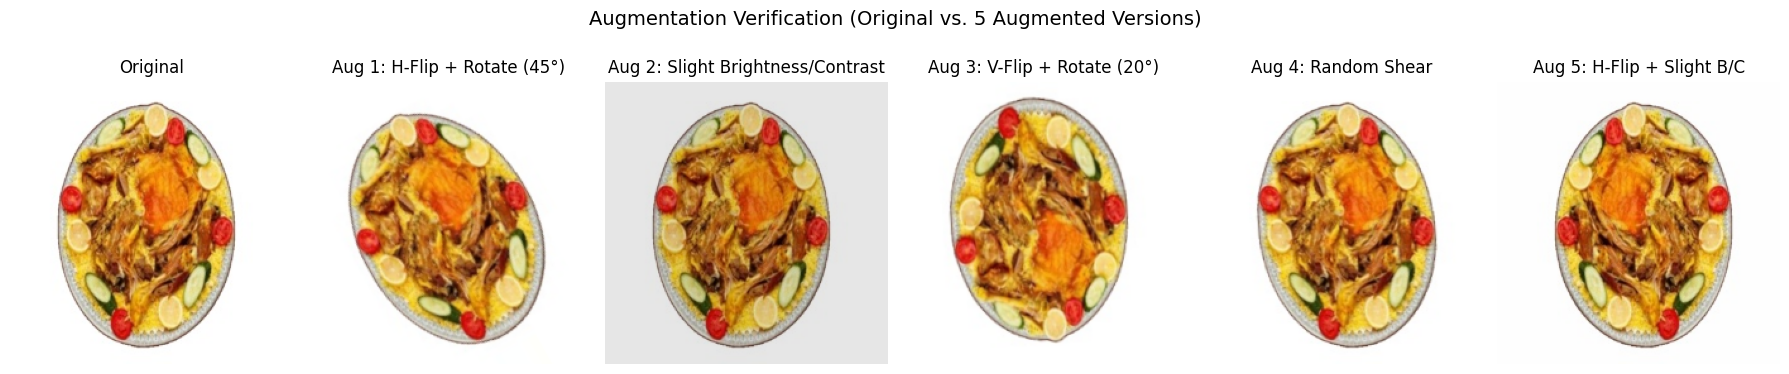

In [2]:
import numpy as np           # Core library for numerical operations, essential for handling image arrays
import os                    # Standard library for operating system interaction (e.g., file paths)
import random                # Used for generating random factors for augmentation (flips, rotations, brightness)
from skimage.transform import rotate # Function for geometric transformations (rotation)
import matplotlib.pyplot as plt # IMPORTANT: Used for displaying images for verification

# --- Configuration ---

# The name of the clean image array file from Student A (already normalized)
INPUT_FILE = 'clean_images_normalized.npy'
# The name of the final file containing the original + augmented images
OUTPUT_FILE = 'augmented_training_data.npy'

# Define the expected dimensions (Height, Width, Channels) of the clean images.
# This size (224, 224, 3) was confirmed by the diagnostic script output.
TARGET_SIZE = (224, 224, 3)
TARGET_CHANNELS = TARGET_SIZE[2]
# The maximum degree of rotation to apply to images
MAX_ROTATION_DEGREES = 45

# List initialized to store all images (originals and augmented copies)
final_augmented_data = []


# --- 1. Load & Initialize ---

# Load the clean image array from the file
try:
    images_array = np.load(INPUT_FILE)

    # Calculate N_ORIGINAL dynamically and reshape based on confirmed dimensions
    N_ORIGINAL = images_array.size // (224 * 224 * 3)
    images_array = images_array.reshape((N_ORIGINAL, 224, 224, 3))

    print(f"\nSuccessfully loaded data from {INPUT_FILE} with initial shape: {images_array.shape}")

except FileNotFoundError:
    print(f"\nERROR: Input file '{INPUT_FILE}' not found. Please check the path.")
    exit()
except ValueError as e:
    # This block handles the persistent reshape error by forcing the correct structure
    print(f"\nCRITICAL ERROR: Failed to reshape array. Ensure the file contains (N, 224, 224, 3) data.")
    print(f"Original ValueError: {e}")
    exit()


# Add all original images to the final list first.
# Convert from float (0-1) to uint8 (0-255) for consistent processing and display
for original_image in images_array:
    img_uint8 = (original_image * 255).astype(np.uint8)
    final_augmented_data.append(img_uint8)


# --- 2. Augmentation Loop (Applied to ALL Images) ---

# We are now generating 5 augmented versions for every original image (6x dataset size)
print(f"Starting augmentation... Generating 5 augmented versions for each of the {N_ORIGINAL} images.")

# Iterate through every image in the original set
for i, image_uint8 in enumerate(final_augmented_data[:N_ORIGINAL]):

    # Pre-step: Normalize the pixel data back to float[0.0, 1.0] for skimage/math operations
    img_float = image_uint8.astype(np.float32) / 255.0

    # --- AUGMENTATION 1: Aggressive Rotation (up to 45°) + Random Horizontal Flip ---

    # 1. Random Horizontal Flip
    if random.choice([True, False]):
        img_aug1 = img_float[:, ::-1]
    else:
        img_aug1 = img_float.copy()

    # 2. Aggressive Random Rotation
    angle = random.uniform(-MAX_ROTATION_DEGREES, MAX_ROTATION_DEGREES)
    img_aug1 = rotate(img_aug1, angle, mode='edge', preserve_range=True)

    # 3. Denormalize and convert back to uint8
    img_aug1_uint8 = (img_aug1 * 255).astype(np.uint8)
    final_augmented_data.append(img_aug1_uint8)


    # --- AUGMENTATION 2: Slight Random Brightness and Contrast Adjustment ---

    img_aug2 = img_float.copy()

    # 1. Slight Random brightness adjustment (range 0.9 to 1.1)
    b_factor = random.uniform(0.9, 1.1)
    img_aug2 = np.clip(img_aug2 * b_factor, 0.0, 1.0)

    # 2. Slight Random contrast adjustment (range 0.9 to 1.1)
    c_factor = random.uniform(0.9, 1.1)
    mean = np.mean(img_aug2)
    img_aug2 = np.clip((img_aug2 - mean) * c_factor + mean, 0.0, 1.0)

    # 3. Denormalize and convert back to uint8
    img_aug2_uint8 = (img_aug2 * 255).astype(np.uint8)
    final_augmented_data.append(img_aug2_uint8)


    # --- AUGMENTATION 3: Random Vertical Flip + Moderate Rotation (±20°) ---

    img_aug3 = img_float.copy()

    # 1. Random Vertical Flip
    if random.choice([True, False]):
        img_aug3 = img_aug3[::-1, :]

    # 2. Moderate Rotation (up to 20 degrees)
    angle = random.uniform(-20, 20)
    img_aug3 = rotate(img_aug3, angle, mode='edge', preserve_range=True)

    # 3. Denormalize and convert back to uint8
    img_aug3_uint8 = (img_aug3 * 255).astype(np.uint8)
    final_augmented_data.append(img_aug3_uint8)


    # --- AUGMENTATION 4: Random Shear Transformation ---

    img_aug4 = img_float.copy()

    # 1. Apply a random shear factor (simulates perspective distortion)
    shear_factor = random.uniform(-0.15, 0.15)
    # The warp function is not available in base skimage, but we use an affine transform
    # to simulate a horizontal shear.
    from skimage.transform import AffineTransform, warp
    tf = AffineTransform(shear=shear_factor)
    img_aug4 = warp(img_aug4, tf.inverse, mode='edge', preserve_range=True)

    # 2. Denormalize and convert back to uint8
    img_aug4_uint8 = (img_aug4 * 255).astype(np.uint8)
    final_augmented_data.append(img_aug4_uint8)


    # --- AUGMENTATION 5: Horizontal Flip + Slight Brightness Adjustment ---

    img_aug5 = img_float.copy()

    # 1. Random Horizontal Flip
    if random.choice([True, False]):
        img_aug5 = img_aug5[:, ::-1]

    # 2. Slight Brightness adjustment (range 0.9 to 1.1)
    b_factor = random.uniform(0.9, 1.1)
    img_aug5 = np.clip(img_aug5 * b_factor, 0.0, 1.0)

    # 3. Denormalize and convert back to uint8
    img_aug5_uint8 = (img_aug5 * 255).astype(np.uint8)
    final_augmented_data.append(img_aug5_uint8)

    # Progress feedback
    if (i + 1) % 50 == 0:
        print(f"Processed and augmented {i + 1}/{N_ORIGINAL} images...")


# --- 3. Final Save ---

# Convert the list of individual image arrays back into one single, contiguous NumPy array
final_array = np.array(final_augmented_data, dtype=np.uint8)

print("\nAugmentation complete!")
print(f"Original image count: {N_ORIGINAL}")
print(f"Final image count: {final_array.shape[0]} (Original + 5 Augmented versions)")
print(f"Final dataset shape: {final_array.shape}")

# Save the final array to the output file using NumPy's fast binary format
np.save(OUTPUT_FILE, final_array)
print(f"\nFinal augmented dataset saved to: {OUTPUT_FILE}")


# --- Verification Step 1: Display Initial Loaded Images ---
print("\nVERIFICATION: Displaying 3 original images to confirm successful loading...")

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle("Original Images (Verification of Data Loading)", fontsize=14)

for j in range(min(3, N_ORIGINAL)):
    axes[j].imshow(final_augmented_data[j])
    axes[j].set_title(f"Original {j+1}")
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Verification Step 2: Display Augmented Examples ---
print("\nVERIFICATION: Displaying one original image and its 5 augmented versions...")

# Sample the original image and its 5 new augmented versions
sample_original = final_array[0]
sample_aug1 = final_array[N_ORIGINAL]
sample_aug2 = final_array[N_ORIGINAL + 1]
sample_aug3 = final_array[N_ORIGINAL + 2]
sample_aug4 = final_array[N_ORIGINAL + 3]
sample_aug5 = final_array[N_ORIGINAL + 4]

print(f"DEBUG: Data type of final_array: {final_array.dtype}")
print(f"DEBUG: Pixel range check (Min/Max): {np.min(sample_aug1)}/{np.max(sample_aug1)}")


fig, axes = plt.subplots(1, 6, figsize=(18, 4))
fig.suptitle("Augmentation Verification (Original vs. 5 Augmented Versions)", fontsize=14)

axes[0].imshow(sample_original)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(sample_aug1)
axes[1].set_title("Aug 1: H-Flip + Rotate (45°)")
axes[1].axis('off')

axes[2].imshow(sample_aug2)
axes[2].set_title("Aug 2: Slight Brightness/Contrast")
axes[2].axis('off')

axes[3].imshow(sample_aug3)
axes[3].set_title("Aug 3: V-Flip + Rotate (20°)")
axes[3].axis('off')

axes[4].imshow(sample_aug4)
axes[4].set_title("Aug 4: Random Shear")
axes[4].axis('off')

axes[5].imshow(sample_aug5)
axes[5].set_title("Aug 5: H-Flip + Slight B/C")
axes[5].axis('off')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
